# Trends_AC_AstroML

In [1]:

import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
from scipy import optimize
from astroML.linear_model import TLS_logL
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18




In [37]:
min_func = lambda beta: -TLS_logL(beta, X, dX)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

# Read in Chelsea's data ...
# Use the result of reading her data band by band,  
# keeping only those where:
# Npts  > 10 , Plike - Pnoise  > 2 , Plike - Pinf > 0.05 ,  edge == 0 

# calculating lambdaRF = lambdaOBS / (1+redshift)
# calculating SFinf  = np.power(10, log10sigmahat) * sqrt(np.power(10, log10tau / 365.)  
# calculating tauRF = np.power(10,log10tau  / (1.+ redshift)
# calculating 4000 A values : 
#   SFinf4000 =  SFinf  * np.power(4000 / lambdaRF , -0.479)
#   tau4000 =  tauRF * np.power(4000 /  lambdaRF  , 0.17 )
# cross-matching to Shen2011, with DR7 data,
# adding to each band updated M_BH 

# a dictionary of five filters .... 
s82 = np.load('../code/s82drw_shen2011_dic.npy').item()

    # make identical declarations of variables 
# as in Chelsea's code ..
A = [] ;  C = [] 
#for band in 'ugriz':
band = 'r'
print(band, ' band ')
var = s82[band]['SFinf'].data ** 2.0  # variance in mag^2, equal to 
                                    # sigmahat^2*tau/365 = SF_inf^2 
redshift = s82[band]['REDSHIFT'].data
tauOBS  = s82[band]['log10tau'].data # NOTE : log10tau is observed frame !!!! 
tau = tauOBS-np.log10(1.0+redshift) # correct to rest frame .... 
#tau = s82[band]['log10tau'].data # where tau is best-fit timescale in days
lRF = 6250 / (1.+redshift)
#lRF = s82[band]['lambdaRF'].data # rest-frame wavelength in Angstroms
M_i_corr = s82[band]['MI_Z2'].data#+0.596 # Absolute Magnitude M_i, K-corrected to z=0
mass_bh = s82[band]['LOGBH'].data #  BH mass in log solar masses

#####################
#### SFinf model ####
#####################

select = mass_bh > 0 
print('Of ', len(select), ' quasars in that band, ',select.sum() , ' have M_BH')
f = np.log10(np.sqrt(var))[select]  # SF_inf array
x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
#z = (mass_bh-9.)[select]            # BH mass in 10^9 solar masses
#red = np.log10(1.+redshift)[select]  #  redshift array; not neede
#lum = y
#mbh = z 
# First, remove wavelength trend: 
lampwrsf = - 0.479
fo = f - lampwrsf*x 

# Setup errors 
sigma_lum = 1e-5 #(set arbitrarily small) ; x1
#sigma_mbh = 0.2 # BH mass errors in dex   ; x2
#sigma_z = 1e-5  # (set arbitrarily small) ; NOT USED 
sigma_y = 0.01  # uncertainty in SFinf   ; y1 

y1 = fo  # SFinf 
x1 = y  # luminosity 
#x2 = z # BH mass 

# Fit x1 and y1 :  
# stack the latent variables x1,y1  ....
X = np.vstack((x1, y1)).T
dX = np.zeros((len(x1), 2, 2))
dX[:, 0, 0] = sigma_lum ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 


beta_fit = optimize.fmin(min_func, x0=[-1, 1])
slope, offset  = get_m_b(beta_fit)
print('For band ', band, 'A=', offset, 'C=', slope)

#####################
#### tau model ####
#####################

f = tau[select]
lampwrsf = 0.17
fo = f - lampwrsf*x 

y1 = fo  # tau
x1 = y

X = np.vstack((x1, y1)).T
dX = np.zeros((len(x1), 2, 2))
dX[:, 0, 0] = sigma_lum ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 
beta_fit = optimize.fmin(min_func, x0=[-1, 1])
slope, offset  = get_m_b(beta_fit)
print('For band ', band, 'A=', offset, 'C=', slope)

r  band 
Of  6871  quasars in that band,  6800  have M_BH
For band  r A= -0.11577991931871134 C= 0.280523637811157
Optimization terminated successfully.
         Current function value: 12630214.939382
         Iterations: 63
         Function evaluations: 118
For band  r A= 2.3103041768573056 C= -0.028523133989603145


In [30]:
s82 = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011.txt',
                 format='ascii')
s82['lambdaRF'] = 6250 /  (1.+ s82['redshift'])

In [33]:

var = 2 * (s82['sigmaEXP_sdss-ps1']**2.0)
#var = s82['SFinf'].data ** 2.0  # variance in mag^2, equal to 
                                    # sigmahat^2*tau/365 = SF_inf^2 
                           # 
redshift = s82['redshift'].data
#tauOBS  = s82['log10tau'].data # NOTE : log10tau is observed frame !!!! 
tauOBS = np.log10(s82['tauEXP_sdss'].data)
tau = tauOBS-np.log10(1.0+redshift) # correct to rest frame .... 
#tau = s82[band]['log10tau'].data # where tau is best-fit timescale in days
lRF = s82['lambdaRF'].data # rest-frame wavelength in Angstroms
M_i_corr = s82['M_i'].data#+0.596 # Absolute Magnitude M_i, K-corrected to z=0
mass_bh = s82['mass_BH'].data #  BH mass in log solar masses
#mass_BH

select = mass_bh > 0 
print('Of ', len(select), ' quasars in that band, ',select.sum() , ' have M_BH')
f = np.log10(np.sqrt(var))[select]  # SF_inf array
x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
#z = (mass_bh-9.)[select]            # BH mass in 10^9 solar masses
#red = np.log10(1.+redshift)[select]  #  redshift array; not neede
#lum = y
#mbh = z 
# First, remove wavelength trend: 
lampwrsf = - 0.479
fo = f - lampwrsf*x 

# Setup errors 
sigma_lum = 1e-5 #(set arbitrarily small) ; x1
#sigma_mbh = 0.2 # BH mass errors in dex   ; x2
#sigma_z = 1e-5  # (set arbitrarily small) ; NOT USED 
sigma_y = 0.01  # uncertainty in SFinf   ; y1 

y1 = fo  # SFinf 
x1 = y  # luminosity 
#x2 = z # BH mass 

# Fit x1 and y1 :  
# stack the latent variables x1,y1  ....
X = np.vstack((x1, y1)).T
dX = np.zeros((len(x1), 2, 2))
dX[:, 0, 0] = sigma_lum ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func, x0=[-1, 1])
print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

slope, offset  = get_m_b(beta_fit)
print('For band ', band, 'A=', offset, 'C=', slope)
A.append(offset)
C.append(slope) 

Of  9246  quasars in that band,  5869  have M_BH
Optimization terminated successfully.
         Current function value: 2836548.145027
         Iterations: 75
         Function evaluations: 139
[ 0.03280381 -0.52690499]
For band  r A= -0.5289472724550581 C= 0.06225754533067983


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


(array([1.000e+00, 4.000e+01, 9.600e+01, 2.840e+02, 6.580e+02, 1.948e+03,
        2.459e+03, 1.202e+03, 1.500e+02, 1.000e+00]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ]),
 <a list of 10 Patch objects>)

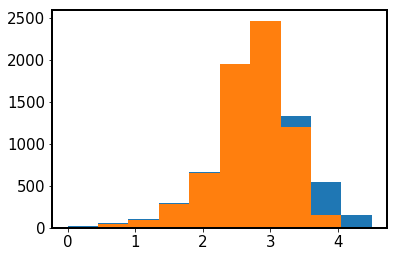

In [20]:
%matplotlib inline
plt.hist(s82_['log10tau'], range=(0,4.5))
plt.hist(s82['r']['log10tau'], range=(0,4.5))